# CitiBike Analysis

This exercise is intended to be run on an AWS EC2 instance. This notebook has the same data handling, but runs against a file on your local filesystem. The file `2013-12 - Citi Bike trip data.csv` is about 87 MB and is not present in the course GitHub repo. It should be downloaded from <https://s3.amazonaws.com/tripdata/index.html>, unzipped, and copied to the (ignored) output directory of your repo.

The real analysis should be run in notebook `07-2_citibike_analysis_aws_ec2_s3.ipynb` after you have uploaded is to EC2. To be clear, you do *not* have to run this version of the file. This is here so you can check out the CitiBike data *if* you are having trouble configuring your AWS EC2 instance and S3 bucket.

In [1]:
import pandas as pd

path = "output/2013-12 - Citi Bike trip data.csv"

df = pd.read_csv(path)

In [2]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1015,2013-12-01 00:00:03,2013-12-01 00:16:58,401,Allen St & Rivington St,40.720196,-73.989978,476,E 31 St & 3 Ave,40.743943,-73.979661,14729,Subscriber,1979,2
1,962,2013-12-01 00:00:07,2013-12-01 00:16:09,312,Allen St & E Houston St,40.722055,-73.989111,223,W 13 St & 7 Ave,40.737815,-73.999947,17871,Subscriber,1970,2
2,768,2013-12-01 00:00:15,2013-12-01 00:13:03,326,E 11 St & 1 Ave,40.729538,-73.984267,291,Madison St & Montgomery St,40.713126,-73.984844,18508,Subscriber,1982,2
3,218,2013-12-01 00:00:49,2013-12-01 00:04:27,2021,W 45 St & 8 Ave,40.759291,-73.988597,447,8 Ave & W 52 St,40.763707,-73.985162,17745,Subscriber,1976,1
4,550,2013-12-01 00:01:28,2013-12-01 00:10:38,439,E 4 St & 2 Ave,40.726281,-73.989780,296,Division St & Bowery,40.714131,-73.997047,16947,Subscriber,1983,1


### Rename the columns of of the dataframe
Remove the space in names would be easier for the following indexing

In [3]:
df_bike = df.rename(columns={"start station id": "start_station_id", 
                             "start station name": "start_station_name",
                             "start station latitude": "start_station_lat",
                             "start station longitude": "start_station_lon", 
                             "end station id": "end_station_id", 
                             "end station name": "end_station_name", 
                             "end station latitude": "end_station_lat",
                             "end station longitude": "end_station_lon", 
                             "birth year": "birth_year"})
df_bike.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_lat,start_station_lon,end_station_id,end_station_name,end_station_lat,end_station_lon,bikeid,usertype,birth_year,gender
0,1015,2013-12-01 00:00:03,2013-12-01 00:16:58,401,Allen St & Rivington St,40.720196,-73.989978,476,E 31 St & 3 Ave,40.743943,-73.979661,14729,Subscriber,1979,2
1,962,2013-12-01 00:00:07,2013-12-01 00:16:09,312,Allen St & E Houston St,40.722055,-73.989111,223,W 13 St & 7 Ave,40.737815,-73.999947,17871,Subscriber,1970,2
2,768,2013-12-01 00:00:15,2013-12-01 00:13:03,326,E 11 St & 1 Ave,40.729538,-73.984267,291,Madison St & Montgomery St,40.713126,-73.984844,18508,Subscriber,1982,2
3,218,2013-12-01 00:00:49,2013-12-01 00:04:27,2021,W 45 St & 8 Ave,40.759291,-73.988597,447,8 Ave & W 52 St,40.763707,-73.985162,17745,Subscriber,1976,1
4,550,2013-12-01 00:01:28,2013-12-01 00:10:38,439,E 4 St & 2 Ave,40.726281,-73.989780,296,Division St & Bowery,40.714131,-73.997047,16947,Subscriber,1983,1


### Count the number of trajectories from and stop at different stations

In [4]:
start_station = df_bike.groupby('start_station_id').size().to_frame('size')
start_station

,size
start_station_id,
72,1213
79,995
82,558
83,726
116,2763
...,...
2017,665
2021,2015
2022,686


In [5]:
end_station = df_bike.groupby('end_station_id').size().to_frame('size')
end_station

,size
end_station_id,
72,1269
79,1024
82,582
83,669
116,2805
...,...
2017,551
2021,1809
2022,740


#### Rename the axis and prepare for merging
The start station and the end station are both the station id, we cand change the number both as station id

In [6]:
s_station = start_station.rename_axis("station_id")
e_station = end_station.rename_axis("station_id")

#### Merge the start and end station dataframes

In [7]:
SE_station = s_station.merge(e_station, on='station_id')

# rename the size column as number of trips start and end
SE_station = SE_station.rename(columns={"size_x": 'start', "size_y": "end"})
SE_station.head()

,start,end
station_id,,
72,1213,1269
79,995,1024
82,558,582
83,726,669
116,2763,2805


#### Our table has no spatial information, we need join with the original data that has the cooridnate information
Change the index name back to the start_station_id, we going to use this join with the original table.

In [8]:
SE_station = SE_station.rename_axis("start_station_id")
SE_station

,start,end
start_station_id,,
72,1213,1269
79,995,1024
82,558,582
83,726,669
116,2763,2805
...,...,...
2017,665,551
2021,2015,1809
2022,686,740


#### Extract the lon, lat of each stations by removing all duplicate stations info, and then merge with the created table

In [9]:
df_bike_coord = df_bike.drop_duplicates(subset = ["start_station_id"])

df_bike_coord = df_bike_coord.merge(SE_station, on="start_station_id")
df_bike_coord

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_lat,start_station_lon,end_station_id,end_station_name,end_station_lat,end_station_lon,bikeid,usertype,birth_year,gender,start,end
0,1015,2013-12-01 00:00:03,2013-12-01 00:16:58,401,Allen St & Rivington St,40.720196,-73.989978,476,E 31 St & 3 Ave,40.743943,-73.979661,14729,Subscriber,1979,2,1968,1972
1,962,2013-12-01 00:00:07,2013-12-01 00:16:09,312,Allen St & E Houston St,40.722055,-73.989111,223,W 13 St & 7 Ave,40.737815,-73.999947,17871,Subscriber,1970,2,1739,1758
2,768,2013-12-01 00:00:15,2013-12-01 00:13:03,326,E 11 St & 1 Ave,40.729538,-73.984267,291,Madison St & Montgomery St,40.713126,-73.984844,18508,Subscriber,1982,2,2241,2136
3,218,2013-12-01 00:00:49,2013-12-01 00:04:27,2021,W 45 St & 8 Ave,40.759291,-73.988597,447,8 Ave & W 52 St,40.763707,-73.985162,17745,Subscriber,1976,1,2015,1809
4,550,2013-12-01 00:01:28,2013-12-01 00:10:38,439,E 4 St & 2 Ave,40.726281,-73.989780,296,Division St & Bowery,40.714131,-73.997047,16947,Subscriber,1983,1,1752,1923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,1333,2013-12-01 13:46:57,2013-12-01 14:09:10,419,Carlton Ave & Park Ave,40.695807,-73.973556,293,Lafayette St & E 8 St,40.730287,-73.990765,15217,Subscriber,1983,1,42,36
325,177,2013-12-01 14:02:18,2013-12-01 14:05:15,443,Bedford Ave & S 9th St,40.708531,-73.964090,443,Bedford Ave & S 9th St,40.708531,-73.964090,18525,Subscriber,1953,1,80,75
326,170,2013-12-01 14:58:11,2013-12-01 15:01:01,298,3 Ave & Schermerhorn St,40.686832,-73.979677,395,Bond St & Schermerhorn St,40.688070,-73.984106,14589,Subscriber,1960,1,173,203
327,934,2013-12-01 15:02:02,2013-12-01 15:17:36,2005,Railroad Ave & Kay Ave,40.705312,-73.971001,310,State St & Smith St,40.689269,-73.989129,16410,Subscriber,1984,1,47,54


#### Create a GeoPandas based on the lon, lat info in the dataframe

In [10]:
# from shapely.geometry import Point
# from geopandas import GeoDataFrame

# geometry = [Point(xy) for xy in zip(df_bike_coord.end_station_lon, df_bike_coord.end_station_lat)]
# gdf = GeoDataFrame(df_bike_coord, crs="EPSG:4326", geometry=geometry)


from geopandas import GeoDataFrame as gdf
import geopandas as gpd
import pandas as pd

crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/

# create a geo-dataframe
points_gdf = gpd.GeoDataFrame(df_bike_coord, crs=crs, \
                geometry=gpd.points_from_xy(df_bike_coord.end_station_lon, df_bike_coord.end_station_lat))

# save the geo-dataframe as a shapefile
points_gdf.to_file("output/stations.gpkg", driver = "GPKG")

/home/tug30201/miniconda3/envs/gus8066/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

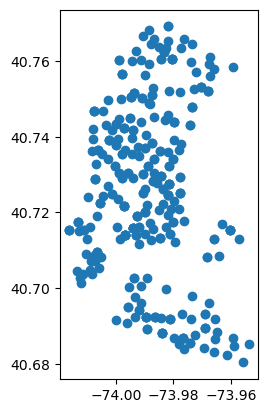

In [11]:
points_gdf.plot()